# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

# Common imports
import numpy as np
import pandas as pd

# To plot figures
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

First let's import TensorFlow and Keras, and check versions.

In [2]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# import keras
from tensorflow import keras

In [3]:
sklearn.__version__

'1.6.1'

In [4]:
tf.__version__

'2.18.0'

In [5]:
keras.__version__

'3.8.0'

`-tf` indicates `tf.keras` implements the Keras API, and some extra TensorFlow-specific features.

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

# Building an Image Classifier Using Sequential API
Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [7]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, the testing set contains 10,000 grayscle images. Each image has 28x28 pixels.

In [8]:
X_train_full.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Each pixel intensity is represented as a byte (0 to 255), integers.

In [9]:
X_train_full.dtype

dtype('uint8')

Rescale the pixels intensities to [0,1] for all datasets.

In [10]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

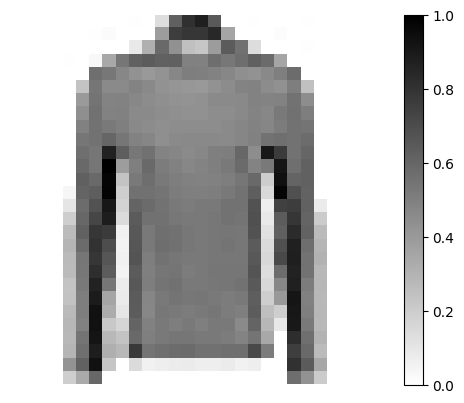

In [11]:
plt.imshow(X_train[2025], cmap="binary")
plt.axis('off')
plt.colorbar()
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [12]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

In [13]:
np.bincount(y_train)

array([5479, 5503, 5510, 5492, 5473, 5497, 5533, 5550, 5485, 5478])

Here is the [link](https://www.tensorflow.org/tutorials/keras/classification) with corresponding class names information.

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [15]:
class_names[y_train[2025]]

'Pullover'

The training set contains 55,000 images, validation set contains 5,000 images, and the test set contains 10,000 images.

In [16]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

Let's take a look at a sample of the images in the dataset:

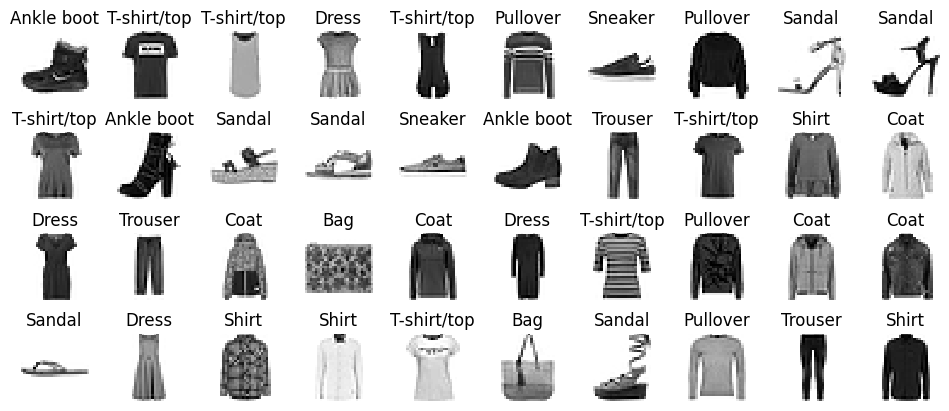

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Creating the model using the Sequential API

Classification MLP with two hidden layers:

In [18]:
tf.random.set_seed(42)

# creates a Sequential model, compsed of a single stack of layers connected sequentially
model = keras.models.Sequential()

# convert input into 1D array, same as use Inputlayer
model.add(keras.layers.InputLayer(shape=[28, 28]))
model.add(keras.layers.Flatten())

# add two dense hidden layers
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))

# dense output layer, each class has one neuron
model.add(keras.layers.Dense(10, activation="softmax"))

Instead of add layers one by one, can also pass a list of layers when creating Sequential model:

```python
model = keras.models.Sequential([
    keras.layers.Flatten(shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
```

In [19]:
keras.backend.clear_session()

The model’s `summary()` method displays all the model’s layers, including each layer’s name, its output shape (None means the batch size can be anything), and its number of parameters.

The summary ends with the total number of parameters, including trainable and non-trainable parameters.

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Dense layers often have a lot of parameters.
* The first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters;
* The second hidden layer has 300 x 100 connection weights, plus 100 bias terms, which adds up to 30,100 parameters;
* The third hidden layer has 100 x 10 connection weights, plus 10 bias terms, which adds up to 1,010 parameters.

The large number of parameters gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

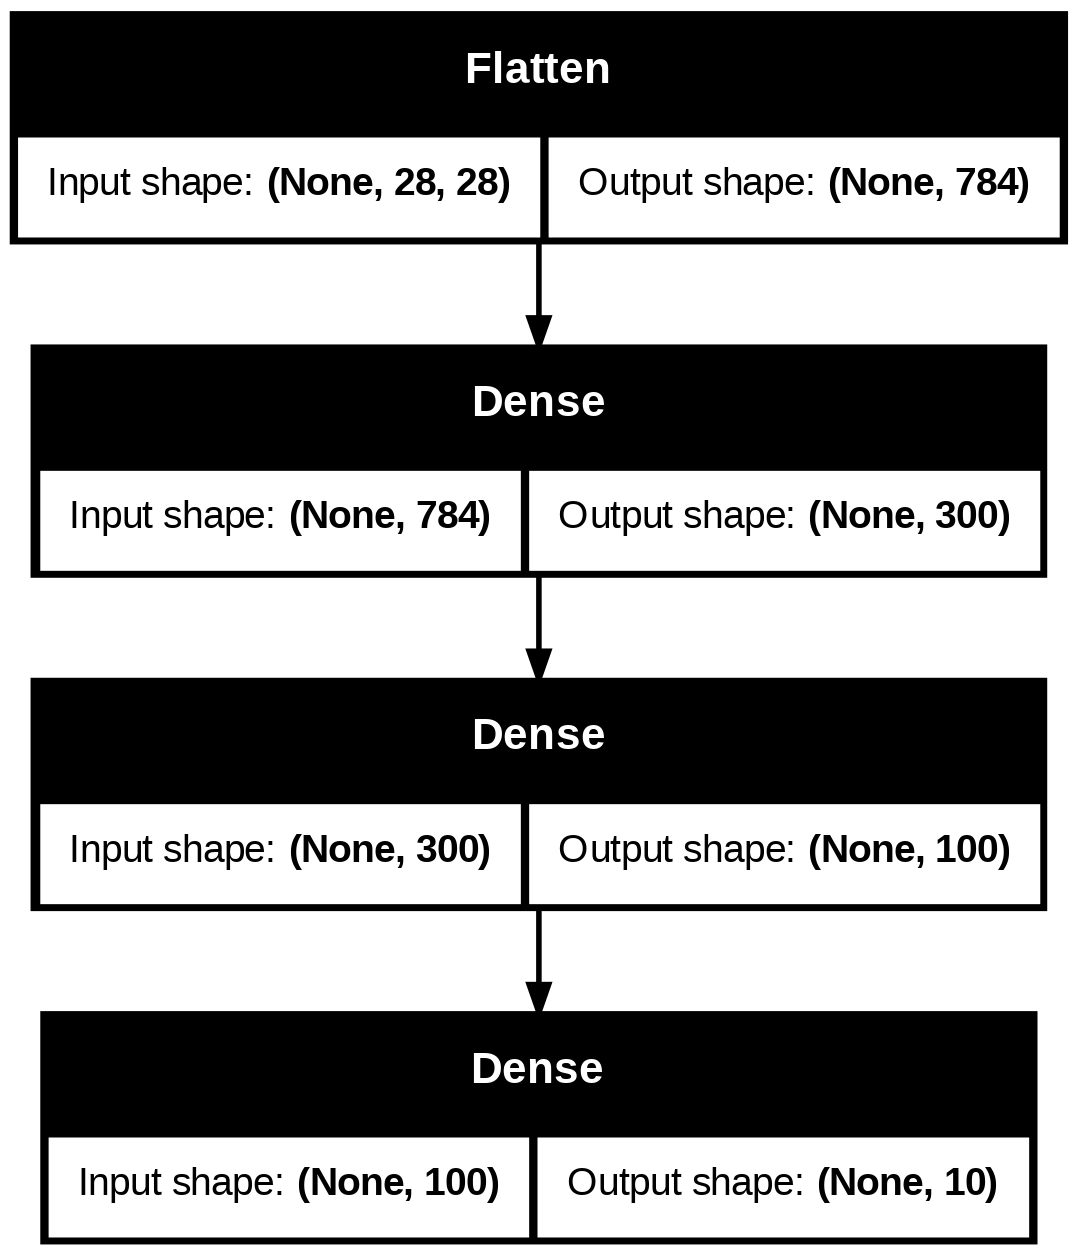

In [21]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

To fetch a layer by index:

In [22]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [23]:
hidden1 = model.layers[1]
print(hidden1.name)
print(model.layers[2].name)

dense
dense_1


In [24]:
model.get_layer('dense_2')

<Dense name=dense_2, built=True>

All the parameters of a layer can be accessed using its `get_weights()` and `set_weights()` methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [25]:
weights, biases = hidden1.get_weights()

In [26]:
weights

array([[ 0.03529458, -0.05679902, -0.02316741, ..., -0.03819644,
        -0.02421531, -0.02961979],
       [-0.07004492,  0.01982198, -0.05292741, ..., -0.03155846,
         0.04518557, -0.03890534],
       [-0.04258458,  0.00360953, -0.01193586, ...,  0.03419887,
        -0.00774501, -0.01215151],
       ...,
       [ 0.07084465, -0.06569246, -0.00571762, ..., -0.04764929,
         0.0384723 ,  0.00012676],
       [ 0.00358384, -0.00939232,  0.02129631, ...,  0.05439024,
        -0.01049655,  0.05900183],
       [ 0.04280992, -0.06347665, -0.01044705, ...,  0.02413853,
         0.00149122,  0.00381275]], dtype=float32)

In [27]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
weights.shape, biases.shape

((784, 300), (300,))

Notice that the Dense layer initialized the connection weights randomly, and the biases were initialized to zeros.

If you ever want to use a different initialization method, you can set `kernel_initializer` (kernel is another name for the matrix of connection weights) or `bias_initializer` when creating the layer. More details can be found in [here](https://keras.io/initializers).

The shape of the weight matrix depends on the number of inputs. If you know the input shape when creating the model, it is best to specify it.

#### Compilng the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function : to measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* Optimizer: to indicates how the model is updated based on the data it sees and its loss function.
* Metrics: to monitor the training and testing steps.

Optionally, you can specify a list of extra metrics to compute during training and evaluation.

You can also check the full list of [loss functions](https://keras.io/losses), [optimizers](https://keras.io/optimizers), and [metrics](https://keras.io/metrics).

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [30]:
# convert class ids to one-hot vectors
tf.keras.utils.to_categorical([2, 0, 2, 8], num_classes=10)

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [31]:
# convert one-hot vectors to class ids
np.argmax(
    [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
    axis=1
)

array([2, 0, 2, 8])

#### Training and evaluating the model

Instead of passing a validation set using the validation_data argument, you could set `validation_split` to the ratio of the training set that you want Keras to use for validation.

In [32]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6830 - loss: 1.0129 - val_accuracy: 0.8290 - val_loss: 0.5049
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8266 - loss: 0.5068 - val_accuracy: 0.8382 - val_loss: 0.4468
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8439 - loss: 0.4510 - val_accuracy: 0.8474 - val_loss: 0.4221
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8536 - loss: 0.4209 - val_accuracy: 0.8510 - val_loss: 0.4068
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8602 - loss: 0.3994 - val_accuracy: 0.8562 - val_loss: 0.3955
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8665 - loss: 0.3825 - val_accuracy: 0.8600 - val_loss: 0.3860
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8698 - loss: 0.3684 - val_accuracy: 0.8616 - val_loss: 0.3785
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8738 - loss: 0.3562 - 

* If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the `class_weight` argument when calling the fit() method, which would give a larger weight to underrepresented classes and a lower weight to overrepresented classes. These weights would be used by Keras when computing the loss.
* If you need per-instance weights, set the `sample_weight` argument. Per-instance weights could be useful if some instances were labeled by experts while others were labeled using a crowdsourcing platform: you might want to give more weight to the former.
* If both `class_weight` and `sample_weight` are provided, Keras multiplies them.

The `fit()` method returns a History object:
* training parameters: `history.params`
* epochs it went through `history.epoch`
* most importantly a dictionary `history.history` containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set.

In [33]:
print('training parameters:', history.params)
print()
print('training epoch:', history.epoch)
print()
print('training metrics:', history.history.keys())

training parameters: {'verbose': 'auto', 'epochs': 30, 'steps': 1719}

training epoch: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

training metrics: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


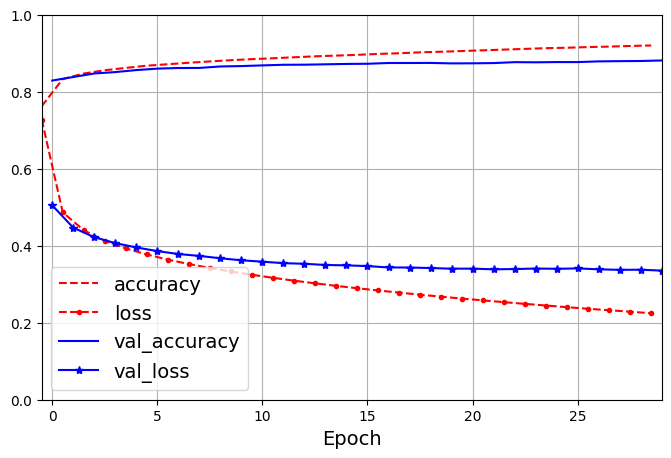

In [34]:
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()


If you are not satisfied with the performance of the model, you should go back and tune the hyperparameters.

* The first one to check is the *learning rate*.
* If that doesn’t help, try another *optimizer*.  
* If the performance is still not great, then try tuning model hyperparameters such as: *the number of layers*, *the number of neurons per layer*, and the types of *activation functions* to use for each hidden layer.
* You can also try tuning other hyperparameters, such as the *batch size* (it can be set in the `fit()` method using the `batch_size` argument, which defaults to 32).

* **Always retune the learning rate after changing any hyperparameter.**

Once you are satisfied with the model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production.

In [35]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8743 - loss: 0.3613


[0.35788694024086, 0.8754000067710876]

#### Using the model to make predictions

In [36]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.02, 0.  , 0.82],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [37]:
y_pred = model.predict(X_new)
np.array(class_names)[np.argmax(y_pred, axis=1)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [38]:
np.array(class_names)[y_test[:3]]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

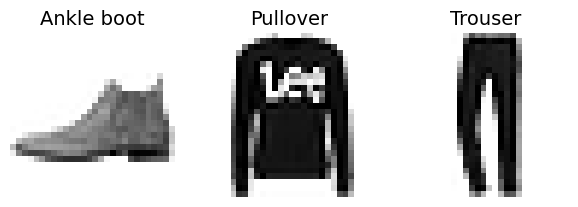

In [39]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Building a Regression MLP using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [40]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

Using the Sequential API to build, train, evaluate, and use a regression MLP to make predictions is quite similar to what we did for classification.

The main differences are:
* the output layer has a single neuron and uses no activation function
* the loss function is the mean squared error.
* use a single hidden layer with fewer neurons than before, to avoid overfitting

In [41]:
tf.random.set_seed(42)
# create model
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# train
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# predict
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 1.3606 - loss: 1.9995 - val_RootMeanSquaredError: 0.6807 - val_loss: 0.4633
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6334 - loss: 0.4018 - val_RootMeanSquaredError: 0.5884 - val_loss: 0.3462
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6009 - loss: 0.3613 - val_RootMeanSquaredError: 0.6088 - val_loss: 0.3707
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5879 - loss: 0.3458 - val_RootMeanSquaredError: 0.6444 - val_loss: 0.4152
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5787 - loss: 0.3350 - val_RootMeanSquaredError: 0.6635 - val_loss: 0.4403
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5696 - loss: 0.3246 - val_RootMeanSquaredError: 0.5840 - val_loss: 0.3411
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5647 - loss: 0.3189 -

In [42]:
print(rmse_test)
print(y_pred)

0.5332791209220886
[[0.436885]
 [1.199105]
 [4.986472]]


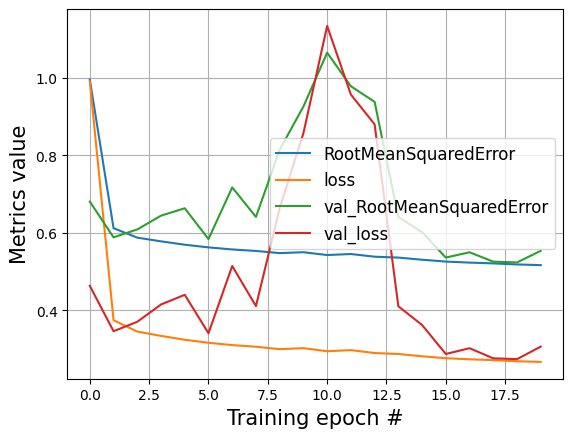

In [43]:
df = pd.DataFrame(history.history)
df.plot()
plt.grid(True)
plt.xlabel('Training epoch #', fontsize = 15)
plt.ylabel('Metrics value', fontsize = 15)
plt.legend(fontsize = 12)
plt.show()

# Building Complex Models using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.



<img src="https://drive.google.com/uc?id=1WHJvxbVHU2cQAPKaha5QxR1LFXNYtZ9t" width="200">

Build a neural network to tackle the California housing problem.

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [45]:
normalization_layer = keras.layers.Normalization()
hidden_layer1 = keras.layers.Dense(30, activation="relu")
hidden_layer2 = keras.layers.Dense(30, activation="relu")
concat_layer = keras.layers.Concatenate()
output_layer = keras.layers.Dense(1)

input_ = keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [46]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 8)              │             17 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 30)             │            270 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 30)             │            930 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 38)             │              0 │ normalization[0][0],   │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             39 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [47]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 8))
  warnings.warn(msg)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 1.8573 - loss: 3.6228 - val_RootMeanSquaredError: 0.8415 - val_loss: 0.7081
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7444 - loss: 0.5564 - val_RootMeanSquaredError: 0.6699 - val_loss: 0.4488
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 0.6595 - loss: 0.4356 - val_RootMeanSquaredError: 0.6155 - val_loss: 0.3788
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6326 - loss: 0.4005 - val_RootMeanSquaredError: 0.5989 - val_loss: 0.3587
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6191 - loss: 0.3835 - val_RootMeanSquaredError: 0.5985 - val_loss: 0.3582
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6099 - loss: 0.3722 - val_RootMeanSquaredError: 0.6520 - val_loss: 0.4251
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6032 - loss: 0.3641 -

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 8))
  warnings.warn(msg)


What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

<img src="https://drive.google.com/uc?id=17j4DMUIX9eVeAZDn5k1hyD8Nhgc3NHnl" width="200">


In [48]:
tf.random.set_seed(42)  # extra code

input_wide = keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = keras.layers.Normalization()
norm_layer_deep = keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([norm_wide, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [49]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 6)              │             13 │ input_layer_2[0][0]    │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 30)             │            210 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 5)              │             11 │ input_layer_1[0][0]    │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 30)             │            930 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35)             │              0 │ normalization_1[0][0], │
│ (Concatenate)             │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             36 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,200 (4.70 KB)

 Trainable params: 1,176 (4.59 KB)

 Non-trainable params: 24 (104.00 B)

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20, validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.7108 - loss: 3.0285 - val_RootMeanSquaredError: 0.9727 - val_loss: 0.9462
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7912 - loss: 0.6266 - val_RootMeanSquaredError: 0.7768 - val_loss: 0.6033
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7140 - loss: 0.5100 - val_RootMeanSquaredError: 0.6995 - val_loss: 0.4893
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6759 - loss: 0.4570 - val_RootMeanSquaredError: 0.6385 - val_loss: 0.4077
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6456 - loss: 0.4169 - val_RootMeanSquaredError: 0.6777 - val_loss: 0.4593
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6207 - loss: 0.3853 - val_RootMeanSquaredError: 0.6800 - val_loss: 0.4624
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6042 - los

Adding an auxiliary output for regularization:

<img src="https://drive.google.com/uc?id=1AvBjOdYgTOyzlP8aWDuGrhqkZWFZlyrP" width="200">


In [51]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [52]:
input_wide = keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = keras.layers.Normalization()
norm_layer_deep = keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([norm_wide, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)
model = keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

Warning: in recent versions, Keras requires one metric per output

In [53]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

In [54]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - dense_2_RootMeanSquaredError: 1.4766 - dense_2_loss: 2.2670 - dense_3_RootMeanSquaredError: 1.9023 - dense_3_loss: 3.7160 - loss: 2.4119 - val_dense_2_RootMeanSquaredError: 0.8149 - val_dense_2_loss: 0.6639 - val_dense_3_RootMeanSquaredError: 2.2872 - val_dense_3_loss: 5.2289 - val_loss: 1.1208
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.7416 - dense_2_loss: 0.5504 - dense_3_RootMeanSquaredError: 0.9265 - dense_3_loss: 0.8597 - loss: 0.5813 - val_dense_2_RootMeanSquaredError: 0.6855 - val_dense_2_loss: 0.4698 - val_dense_3_RootMeanSquaredError: 1.2297 - val_dense_3_loss: 1.5116 - val_loss: 0.5741
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.6813 - dense_2_loss: 0.4645 - dense_3_RootMeanSquaredError: 0.7871 - dense_3_loss: 0.6197 - loss: 0.4800 - val_dense_2_RootMeanSquaredError: 0.6332 - val_dense_2_loss: 0.4009 - val_dense_3_RootMeanSquaredError: 0.9

In [55]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss = eval_results[:3]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - dense_2_RootMeanSquaredError: 0.5774 - dense_2_loss: 0.3335 - dense_3_RootMeanSquaredError: 0.6293 - dense_3_loss: 0.3961 - loss: 0.3398


In [56]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [57]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


# Using the subclassing API to build Dynamic Models

In [58]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = keras.layers.Normalization()
        self.norm_layer_deep = keras.layers.Normalization()
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [59]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))

eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.4798 - RootMeanSquaredError_1: 2.0889 - loss: 2.5013 - mse_loss: 4.4922 - val_RootMeanSquaredError: 1.0191 - val_RootMeanSquaredError_1: 1.7863 - val_loss: 1.2538 - val_mse_loss: 3.1897
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7394 - RootMeanSquaredError_1: 0.9793 - loss: 0.5889 - mse_loss: 0.9611 - val_RootMeanSquaredError: 0.6669 - val_RootMeanSquaredError_1: 0.9060 - val_loss: 0.4823 - val_mse_loss: 0.8206
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6827 - RootMeanSquaredError_1: 0.8127 - loss: 0.4859 - mse_loss: 0.6608 - val_RootMeanSquaredError: 0.6551 - val_RootMeanSquaredError_1: 0.7461 - val_loss: 0.4420 - val_mse_loss: 0.5565
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6532 - RootMeanSquaredError_1: 0.7641 - loss: 0.4427 - mse_loss: 0.5841 - val_RootMeanSquaredError: 0.6141 - val_RootMeanSquaredEr

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


# Saving and Restoring a Model


When using the Sequential API or the Functional API, we want to save and re-load the model.

Keras utilizes the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have).

Warning: Keras now recommends using the `.keras` format to save models, and the `h5` format for weights.

In [60]:
import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [61]:
model.export("my_keras_model")

Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  134475206077968: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  134475206078160: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  134475206072592: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  134475206071824: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  134475167350224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134475167341776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134475167347344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134475167346384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134475167345040: TensorSpec(shape=

In [62]:
from pathlib import Path

# show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


load a SavedModel as a `keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [63]:
tfsm_layer = keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

Warning: Keras now requires the saved weights to have the `.weights.h5` extension.

In [64]:
model.save_weights("my_weights.weights.h5")

In [65]:
model.load_weights("my_weights.weights.h5")

To save a model using the `.keras` format, simply use `model.save()`.

To load a `.keras` model, use the `tf.keras.models.load_model()` function. If the model uses any custom object, you must pass them to the function via the custom_objects argument:

In [66]:
model.save("my_model.keras")

In [67]:
loaded_model = keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)


# Using Callbacks during Training

If the training lasts several hours, we should not only save the model at the end of training, but also save checkpoints at regular intervals during training, to avoid losing everything if the computer crashes.

In [68]:
shutil.rmtree("my_checkpoints", ignore_errors=True)

The `fit()` method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch.

For example, the `ModelCheckpoint` callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch.

Can set `save_best_only=True` when creating the ModelCheckpoint. In this case, it will only save the model when its performance on the validation set is the best so far.

In [69]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5953 - RootMeanSquaredError_1: 0.6497 - loss: 0.3613 - mse_loss: 0.4222 - val_RootMeanSquaredError: 0.7534 - val_RootMeanSquaredError_1: 0.8611 - val_loss: 0.5850 - val_mse_loss: 0.7412
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5922 - RootMeanSquaredError_1: 0.6446 - loss: 0.3573 - mse_loss: 0.4157 - val_RootMeanSquaredError: 0.8516 - val_RootMeanSquaredError_1: 1.0029 - val_loss: 0.7533 - val_mse_loss: 1.0055
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5895 - RootMeanSquaredError_1: 0.6402 - loss: 0.3538 - mse_loss: 0.4099 - val_RootMeanSquaredError: 0.7645 - val_RootMeanSquaredError_1: 0.8417 - val_loss: 0.5969 - val_mse_loss: 0.7082
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5858 - RootMeanSquaredError_1: 0.6351 - loss: 0.3492 - mse_loss: 0.4035 - val_RootMeanSquaredError: 0.8784 - val_RootMeanSquaredEr

Another way to implement early stopping is to simply use the `EarlyStopping` callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (`patience` argument), and if you set `restore_best_weights=True` it will roll back to the best model at the end of training. You can combine both callbacks to save checkpoints of your model in case your computer crashes, and interrupt training early when there is no more progress, to avoid wasting time and resources and to reduce overfitting

In [70]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5719 - RootMeanSquaredError_1: 0.6145 - loss: 0.3322 - mse_loss: 0.3778 - val_RootMeanSquaredError: 0.7581 - val_RootMeanSquaredError_1: 0.8206 - val_loss: 0.5846 - val_mse_loss: 0.6732
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5681 - RootMeanSquaredError_1: 0.6116 - loss: 0.3280 - mse_loss: 0.3741 - val_RootMeanSquaredError: 0.8044 - val_RootMeanSquaredError_1: 0.9805 - val_loss: 0.6784 - val_mse_loss: 0.9610
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5701 - RootMeanSquaredError_1: 0.6112 - loss: 0.3299 - mse_loss: 0.3736 - val_RootMeanSquaredError: 0.7449 - val_RootMeanSquaredError_1: 0.8023 - val_loss: 0.5638 - val_mse_loss: 0.6434
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.5696 - RootMeanSquaredError_1: 0.6105 - loss: 0.3293 - mse_loss: 0.3728 - val_RootMeanSquaredError: 0.8171 - val_RootMeanSquar

In [71]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [72]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.58
Epoch=1, val/train=1.10
Epoch=2, val/train=1.39
Epoch=3, val/train=0.99
Epoch=4, val/train=1.06
Epoch=5, val/train=1.03
Epoch=6, val/train=0.99
Epoch=7, val/train=1.21
Epoch=8, val/train=1.01
Epoch=9, val/train=1.21


# Fine-Tuning Neural Network Hyperparameters

In [73]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more.

To obtain the best combination of hyperparameters work for the task, we can simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation). For example, we can use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space.

However, there’s a better way: we can use the `Keras Tuner` library, which is a hyperparameter tuning library for Keras models. It offers several tuning strategies, it’s highly customizable, and it has excellent integration with TensorBoard. Let’s see how to use it.

In [74]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [75]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

Let's write a function that builds, compiles, and returns a Keras model. The function must take a `kt.HyperParameters` object as an argument, which it can use to define hyperparameters (integers, floats, strings, etc.) along with their range of possible values, and these hyperparameters may be used to build and compile the model.

For example, the following function builds and compiles an MLP to classify Fashion MNIST images, using hyperparameters such as the number of hidden layers (n_hidden), the number of neurons per layer (n_neurons), the learning rate (learning_rate), and the type of optimizer to use (optimizer)

In [76]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model


The `RandomSearch` tuner first calls `build_model()` once with an empty `Hyperparameters` object, just to gather all the hyperparameter specifications. Then, in this example, it runs 5 trials; for each trial it builds a model using hyperparameters sampled randomly within their respective ranges, then it trains that model for 10 epochs and saves it to a subdirectory of the `my_fashion_mnist/my_rnd_search` directory.

Since `overwrite=True`, the `my_rnd_search` directory is deleted before training starts.
If run this code a second time but with `overwrite=False` and `max_​tri⁠als=10`, the tuner will continue tuning where it left off, running 5 more trials: this means we don’t have to run all the trials in one shot.

Lastly, since objective is set to `val_accuracy`, the tuner prefers models with a higher validation accuracy.

In [77]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)

random_search_tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 42s]
val_accuracy: 0.8399999737739563

Best val_accuracy So Far: 0.848800003528595
Total elapsed time: 00h 03m 26s


In [78]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [79]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

Each tuner is guided by a so-called `oracle`: before each trial, the tuner asks the oracle to tell it what the next trial should be. The `RandomSearch` tuner uses a `RandomSearchOracle`, which is pretty basic: it just picks the next trial randomly, as we saw earlier. Since the oracle keeps track of all the trials, you can ask it to give you the best one, and you can display a summary of that trial

In [80]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.848800003528595


In [81]:
best_trial.metrics.get_last_value("val_accuracy")

np.float64(0.848800003528595)

In [82]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8755 - loss: 0.3334
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8811 - loss: 0.3196
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8854 - loss: 0.3087
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8889 - loss: 0.3003
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8934 - loss: 0.2913
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8952 - loss: 0.2841
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.2772
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2705
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9041 - loss: 0.2646
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9046 - loss: 0.2598
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8569 - loss: 0.4225


In some cases, you may want to fine-tune data preprocessing hyperparameters, or `model.fit()` arguments, such as the batch size. For this, you must use a slightly different technique: instead of writing a `build_model()` function, you must subclass the `kt.HyperModel` class and define two methods, `build()` and `fit()`.

The `build()` method does the exact same thing as the `build_model()` function. The `fit()` method takes a HyperParameters object and a compiled model as an argument, as well as all the `model.fit()` arguments, and fits the model and returns the History object. Crucially, the `fit()` method may use hyperparameters to decide how to preprocess the data, tweak the batch size, and more.

In [83]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [84]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

it starts by training many different models for few epochs, then it eliminates the worst models and keeps only the top `1 / factor` models, repeating this selection process until a single model is left.

The max_epochs argument controls the max number of epochs that the best model will be trained for.

The whole process is repeated twice in this case.

| Bracket | Initial Trials (N) | Epochs for First Round |
|---------|--------------------|------------------------|
| 0       | 27                 | 1                      |
| 1       | 9                  | 3                      |
| 2       | 3                  | 9                      |
| 3       | 1                  | 10                     |


27+9+3+1 = 40
40*2 = 80

In [85]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb])

Trial 60 Complete [00h 00m 41s]
val_accuracy: 0.8127999901771545

Best val_accuracy So Far: 0.871999979019165
Total elapsed time: 00h 18m 06s


However, Keras Tuner also includes a `kt.BayesianOptimization` tuner: this algorithm gradually learns which regions of the hyperparameter space are most promising by fitting a probabilistic model called a `Gaussian process`. This allows it to gradually zoom in on the best hyperparameters. The downside is that the algorithm has its own hyperparameters: alpha represents the level of noise you expect in the performance measures across trials, and beta specifies how much you want the algorithm to explore, instead of simply exploiting the known good regions of hyperparameter space.

In [86]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.840399980545044

Best val_accuracy So Far: 0.8615999817848206
Total elapsed time: 00h 07m 03s


Using randomized search is not too hard, and it works well for many fairly simple problems. When training is slow, however (e.g., for more complex problems with larger datasets), this approach will only explore a tiny portion of the hyperparameter space.

You can partially alleviate this problem by assisting the search process manually:
* first run a quick random search using wide ranges of hyperparameter values,
* then run another search using smaller ranges of values centered on the best ones found during the first run, and so on.
This approach will hopefully zoom in on a good set of hyperparameters. However, it’s very time consuming, and probably not the best use of your time.

Fortunately, there are many techniques to explore a search space much more efficiently than randomly. Their core idea is simple: when a region of the space turns out to be good, it should be explored more. Such techniques take care of the “zooming” process for you and lead to much better solutions in much less time.

Here are some Python libraries you can use to optimize hyperparameters:

[Hyperopt](https://github.com/hyperopt/hyperopt): A popular library for optimizing over all sorts of complex search spaces (including real values, such as the learning rate, and discrete values, such as the number of layers).

[Hyperas](https://github.com/maxpumperla/hyperas), [kopt](https://github.com/Avsecz/kopt), or [Talos](https://github.com/autonomio/talos): Useful libraries for optimizing hyperparameters for Keras models (the first two are based on Hyperopt).

[Keras Tuner](https://www.youtube.com/watch?v=Un0JDL3i5Hg&t=24s): An easy-to-use hyperparameter optimization library by Google for Keras models, with a hosted service for visualization and analysis.

[Scikit-Optimize (skopt)](https://scikit-optimize.github.io/stable/): A general-purpose optimization library. The BayesSearchCV class performs Bayesian optimization using an interface similar to GridSearchCV.

[Spearmint](https://github.com/JasperSnoek/spearmint): A Bayesian optimization library.

[Hyperband](https://github.com/zygmuntz/hyperband)
A fast hyperparameter tuning library based on the recent Hyperband paper22 by Lisha Li et al.

[Sklearn-Deap](https://github.com/rsteca/sklearn-deap): A hyperparameter optimization library based on evolutionary algorithms, with a GridSearchCV-like interface.

Moreover, many companies offer services for hyperparameter optimization. Such as [Google Cloud AI Platform’s hyperparameter tuning service](https://cloud.google.com/ai-platform/training/docs/using-hyperparameter-tuning). Other options include services by [Arimo](https://arimo.com) and [SigOpt](https://sigopt.com), and [CallDesk’s Oscar](http://oscar.calldesk.ai).

Hyperparameter tuning is still an active area of research, and evolutionary algorithms are making a comeback. For example, check out [DeepMind’s excellent 2017 paper](https://arxiv.org/abs/1711.09846),where the authors jointly optimize a population of models and their hyperparameters. Google has also used an evolutionary approach, not just to search for hyperparameters but also to look for the best neural network architecture for the problem; their AutoML suite is already available as a [cloud service](https://cloud.google.com/automl/). Perhaps the days of building neural networks manually will soon be over? Check out Google’s [post](https://ai.googleblog.com/2018/03/using-evolutionary-automl-to-discover.html) on this topic. In fact, evolutionary algorithms have been used successfully to train individual neural networks, replacing the ubiquitous Gradient Descent! For an example, see the [2017 post](https://eng.uber.com/deep-neuroevolution/) by Uber where the authors introduce their Deep Neuroevolution technique.

But despite all this exciting progress and all these tools and services, it still helps to have an idea of what values are reasonable for each hyperparameter so that you can build a quick prototype and restrict the search space.
The following sections provide guidelines for choosing the number of hidden layers and neurons in an MLP and for selecting good values for some of the main hyperparameters.

### Number of Hidden Layers

For many problems, you can begin with a single hidden layer and get reasonable results. An MLP with just one hidden layer can theoretically model even the most complex functions, provided it has enough neurons. But for complex problems, deep networks have a much higher parameter efficiency than shallow ones: they can model complex functions using exponentially fewer neurons than shallow nets, allowing them to reach much better performance with the same amount of training data.

To understand why, suppose you are asked to draw a forest using some drawing software, but you are forbidden to copy and paste anything. It would take an enormous amount of time: you would have to draw each tree individually, branch by branch, leaf by leaf. If you could instead draw one leaf, copy and paste it to draw a branch, then copy and paste that branch to create a tree, and finally copy and paste this tree to make a forest, you would be finished in no time. Real-world data is often structured in such a hierarchical way, and deep neural networks automatically take advantage of this fact: lower hidden layers model low-level structures (e.g., line segments of various shapes and orientations), intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g., squares, circles), and the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g., faces).

Not only does this hierarchical architecture help DNNs converge faster to a good solution, but it also improves their ability to generalize to new datasets. For example, if you have already trained a model to recognize faces in pictures and you now want to train a new neural network to recognize hairstyles, you can kickstart the training by reusing the lower layers of the first network. Instead of randomly initializing the weights and biases of the first few layers of the new neural network, you can initialize them to the values of the weights and biases of the lower layers of the first network. This way the network will not have to learn from scratch all the low-level structures that occur in most pictures; it will only have to learn the higher-level structures (e.g., hairstyles). This is called *transfer learning*.

In summary, for many problems you can start with just one or two hidden layers and the neural network will work just fine. For instance, you can easily reach above 97% accuracy on the MNIST dataset using just one hidden layer with a few hundred neurons, and above 98% accuracy using two hidden layers with the same total number of neurons, in roughly the same amount of training time. For more complex problems, you can ramp up the number of hidden layers until you start overfitting the training set. Very complex tasks, such as large image classification or speech recognition, typically require networks with dozens of layers (or even hundreds, but not fully connected ones), and they need a huge amount of training data. You will rarely have to train such networks from scratch: it is much more common to reuse parts of a pretrained state-of-the-art network that performs a similar task. Training will then be a lot faster and require much less data.


### Number of Neurons per Hidden Layer

The number of neurons in the input and output layers is determined by the type of input and output your task requires. For example, the MNIST task requires 28 × 28 = 784 input neurons and 10 output neurons.

As for the hidden layers, it used to be common to size them to form a pyramid, with fewer and fewer neurons at each layer—the rationale being that many low-level features can coalesce into far fewer high-level features. A typical neural network for MNIST might have 3 hidden layers, the first with 300 neurons, the second with 200, and the third with 100. However, this practice has been largely abandoned because it seems that using the same number of neurons in all hidden layers performs just as well in most cases, or even better; plus, there is only one hyperparameter to tune, instead of one per layer. That said, depending on the dataset, it can sometimes help to make the first hidden layer bigger than the others.

Just like the number of layers, you can try increasing the number of neurons gradually until the network starts overfitting. But in practice, it’s often simpler and more efficient to pick a model with more layers and neurons than you actually need, then use early stopping and other regularization techniques to prevent it from overfitting.

Vincent Vanhoucke, a scientist at Google, has dubbed this the “stretch pants” approach: instead of wasting time looking for pants that perfectly match your size, just use large stretch pants that will shrink down to the right size. With this approach, you avoid bottleneck layers that could ruin your model. On the flip side, if a layer has too few neurons, it will not have enough representational power to preserve all the useful information from the inputs (e.g., a layer with two neurons can only output 2D data, so if it processes 3D data, some information will be lost). No matter how big and powerful the rest of the network is, that information will never be recovered.

### Learning Rate, Batch Size, and Other Hyperparameters

The numbers of hidden layers and neurons are not the only hyperparameters you can tweak in an MLP. Here are some of the most important ones, as well as tips on how to set them:


* *Learning rate*    
    The learning rate is arguably the most important hyperparameter. In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges). One way to find a good learning rate is to train the model for a few hundred iterations, starting with a very low learning rate (e.g., 10-5) and gradually increasing it up to a very large value (e.g., 10). This is done by multiplying the learning rate by a constant factor at each iteration (e.g., by exp(log(106)/500) to go from 10-5 to 10 in 500 iterations). If you plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate.
        
            

* *Optimizer*    
    Choosing a better optimizer than plain old Mini-batch Gradient Descent (and tuning its hyperparameters) is also quite important.

    
* *Batch size*    
    The batch size can have a significant impact on your model’s performance and training time. The main benefit of using large batch sizes is that hardware accelerators like GPUs can process them efficiently, so the training algorithm will see more instances per second. Therefore, many researchers and practitioners recommend using the largest batch size that can fit in GPU RAM. There’s a catch, though: in practice, large batch sizes often lead to training instabilities, especially at the beginning of training, and the resulting model may not generalize as well as a model trained with a smaller batch size. In April 2018, Yann LeCun even tweeted “Friends don’t let friends use mini-batches larger than 32,” citing a [2018 paper](https://arxiv.org/abs/1804.07612) by Dominic Masters and Carlo Luschi which concluded that using small batches (from 2 to 32) was preferable because small batches led to better models in less training time. Other papers point in the opposite direction, however; in 2017, papers by [Elad Hoffer et al.](https://arxiv.org/abs/1705.08741) and [Priya Goyal et al.](https://arxiv.org/abs/1706.02677) showed that it was possible to use very large batch sizes (up to 8,192) using various techniques such as warming up the learning rate (i.e., starting training with a small learning rate, then ramping it up). This led to a very short training time, without any generalization gap. So, one strategy is to try to use a large batch size, using learning rate warmup, and if training is unstable or the final performance is disappointing, then try using a small batch size instead.
    
    
* *Activation function*    
    In general, the `ReLU` activation function will be a good default for all hidden layers. For the output layer, it really depends on your task.

    
* *Number of iterations*    
    In most cases, the number of training iterations does not actually need to be tweaked: just use early stopping instead.

For more best practices regarding tuning neural network hyperparameters, check out the excellent [2018 paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.